In [1]:
import numpy as np
import pandas as pd
import scipy

In [2]:
from ecoevocrm.consumer_resource_system import *
from ecoevocrm.landscapes import *
import ecoevocrm.utils as utils
import ecoevocrm.viz as viz
import ecoevocrm.coarse_graining as cg
import ecoevocrm.strain_pool

In [3]:
import matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns

----

## Model parameters

### Traits

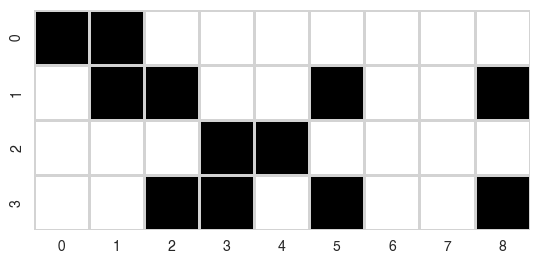

In [4]:
                       # h  h  h  h  h   t   m  m  m
traits_init = np.array([[1, 1, 0, 0, 0,  0,  0, 0, 0],   # pf|A
                        [0, 1, 1, 0, 0,  1,  0, 0, 1],   # pc|A
                        [0, 0, 0, 1, 1,  0,  0, 0, 0],   # pf|B
                        [0, 0, 1, 1, 0,  1,  0, 0, 1]])  # pc|B

viz.matrix_plot(traits_init, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

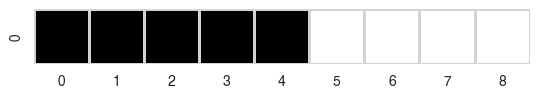

In [5]:
h = 1
consumption_rates = np.array([h, h, h, h, h, 0, 0, 0, 0])  # for all types
viz.matrix_plot(consumption_rates, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

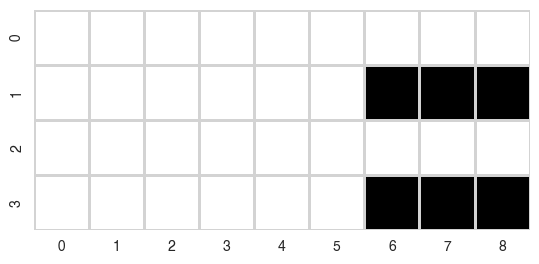

In [6]:
m = 1e-9
mutation_probs = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0],   # pf|A 
                           [0, 0, 0, 0, 0, 0, m, m, m],   # pc|A
                           [0, 0, 0, 0, 0, 0, 0, 0, 0],   # pf|B
                           [0, 0, 0, 0, 0, 0, m, m, m]])  # pc|B
viz.matrix_plot(mutation_probs, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

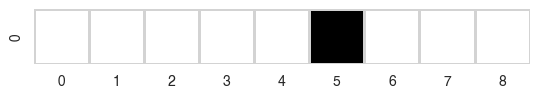

In [7]:
l = 1e-9
segregation_probs = np.array([0, 0, 0, 0, 0, l, 0, 0, 0])  # for all types
viz.matrix_plot(segregation_probs, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

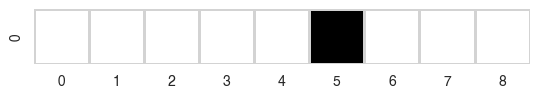

In [8]:
b = 1e-12
a = 1
transfer_donor_rates = np.array([0, 0, 0, 0, 0, b, 0, 0, 0])  # for all types
transfer_recip_rates = np.array([0, 0, 0, 0, 0, a, 0, 0, 0])  # for all types
viz.matrix_plot(transfer_donor_rates, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)
viz.matrix_plot(transfer_recip_rates, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

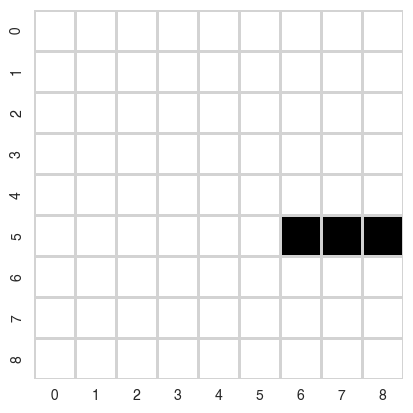

In [9]:
mobile_linkage = np.zeros((traits_init.shape[1], traits_init.shape[1]))
mobile_linkage[5, [6, 7, 8]] = 1
viz.matrix_plot(mobile_linkage, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

In [10]:
N_init = np.ones(traits_init.shape[0])
N_init

array([1., 1., 1., 1.])

### Costs

In [11]:
cost_baseline = np.array([0.1, 0.1, 0.1, 0.1]) 

In [12]:
N = 3
K = 0

In [13]:
landscape_hostA = NKLandscape(N=N, K=K)
landscape_hostA.genotype_fitnesses

{'000': 0.5185781134593419,
 '001': 0.5122689998911556,
 '010': 0.6153503145010012,
 '011': 0.6090412009328149,
 '100': 0.3920611389934674,
 '101': 0.3857520254252811,
 '110': 0.48883334003512663,
 '111': 0.4825242264669403}

In [14]:
landscape_hostB = NKLandscape(N=N, K=K)
landscape_hostB.genotype_fitnesses

{'000': 0.6518545940384376,
 '001': 0.44025704700246376,
 '010': 0.43928891473331094,
 '011': 0.227691367697337,
 '100': 0.6823506437446115,
 '101': 0.4707530967086376,
 '110': 0.46978496443948475,
 '111': 0.25818741740351087}

In [15]:
landscape = merge_landscapes(landscape_hostA.genotype_fitnesses, landscape_hostB.genotype_fitnesses, prefix_A='011001', prefix_B='001101')  # prefixes = traits for pc|A and pc|B

In [16]:
landscape.update({'110000000': 0.3469,   # pf|A
                  '000110000': 0.3117})  # pf|B

In [17]:
landscape

{'011001000': 0.5185781134593419,
 '011001001': 0.5122689998911556,
 '011001010': 0.6153503145010012,
 '011001011': 0.6090412009328149,
 '011001100': 0.3920611389934674,
 '011001101': 0.3857520254252811,
 '011001110': 0.48883334003512663,
 '011001111': 0.4825242264669403,
 '001101000': 0.6518545940384376,
 '001101001': 0.44025704700246376,
 '001101010': 0.43928891473331094,
 '001101011': 0.227691367697337,
 '001101100': 0.6823506437446115,
 '001101101': 0.4707530967086376,
 '001101110': 0.46978496443948475,
 '001101111': 0.25818741740351087,
 '110000000': 0.3469,
 '000110000': 0.3117}

### Environment

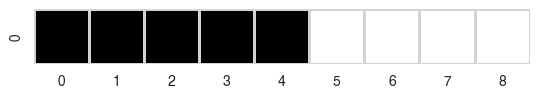

In [18]:
R_init = np.zeros(traits_init.shape[1])
R_init[consumption_rates > 0] = 1
viz.matrix_plot(R_init, vmin=0, vmax=1, cbar=False, linecolor='lightgray', linewidths=1)

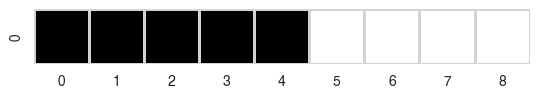

In [19]:
influx_rates = np.zeros(traits_init.shape[1])
influx_rates[consumption_rates > 0] = 1
viz.matrix_plot(influx_rates, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

In [20]:
decay_rates = 1

In [21]:
carrying_capacity = 1e9

## Simulate model

In [22]:
system = ConsumerResourceSystem(traits=traits_init, 
                                consumption_rate=consumption_rates, carrying_capacity=carrying_capacity, 
                                cost_landscape=landscape, cost_baseline=cost_baseline, 
                                mutation_prob=mutation_probs, 
                                influx_rate=influx_rates, decay_rate=decay_rates,
                                N_init=N_init, R_init=R_init, 
                                resource_dynamics_mode='explicit', 
                                convergent_lineages=False)

In [23]:
system.type_set.cost_landscape_bytype

[0.3469, 0.5122689998911556, 0.3117, 0.44025704700246376]

In [24]:
system.type_set.energy_costs

array([0.4469    , 0.612269  , 0.4117    , 0.54025705])

In [25]:
T_total = 1e6

In [26]:
system.run(T=T_total)

<AxesSubplot: >

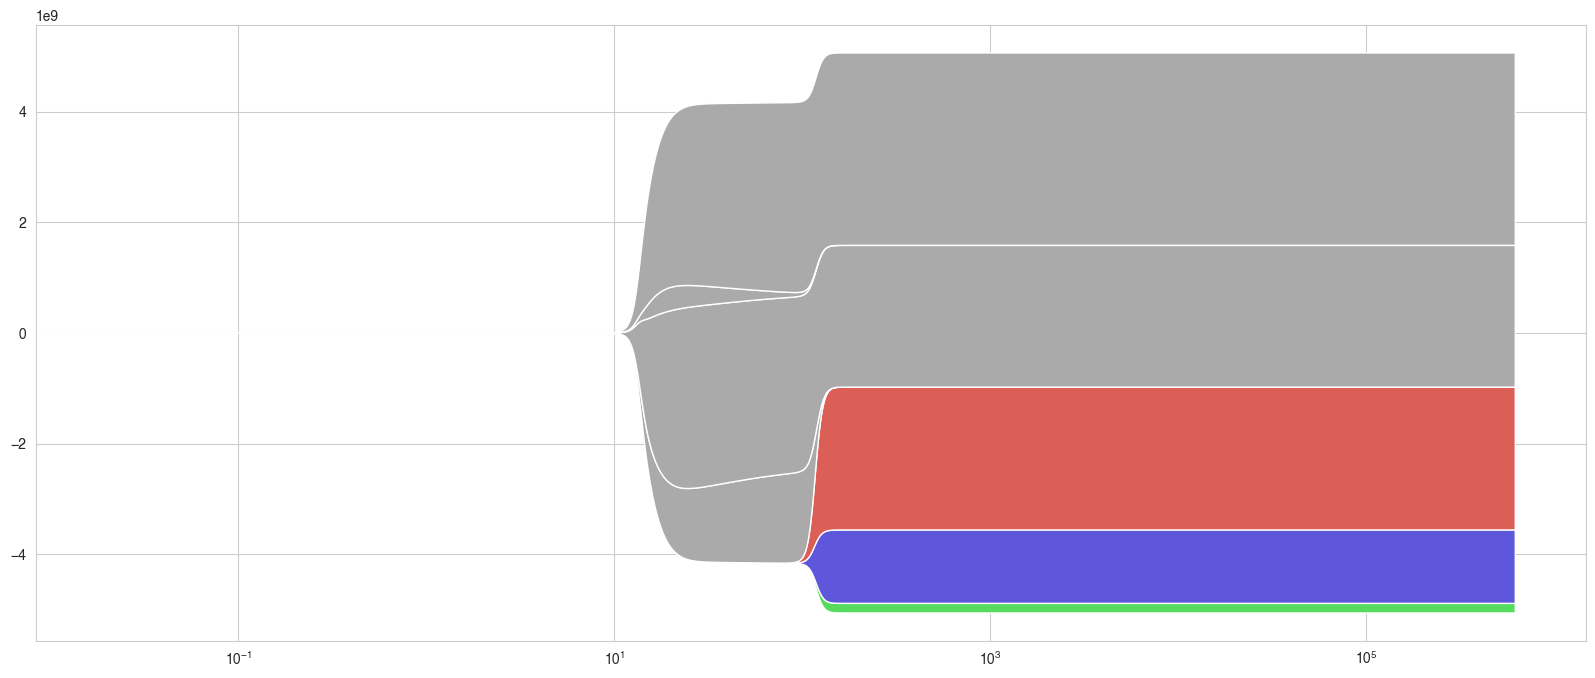

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
viz.stacked_abundance_plot(system, ax=ax, relative_abundance=False, apply_palette_depth=1, log_x_axis=True, color_seed=1)

<AxesSubplot: >

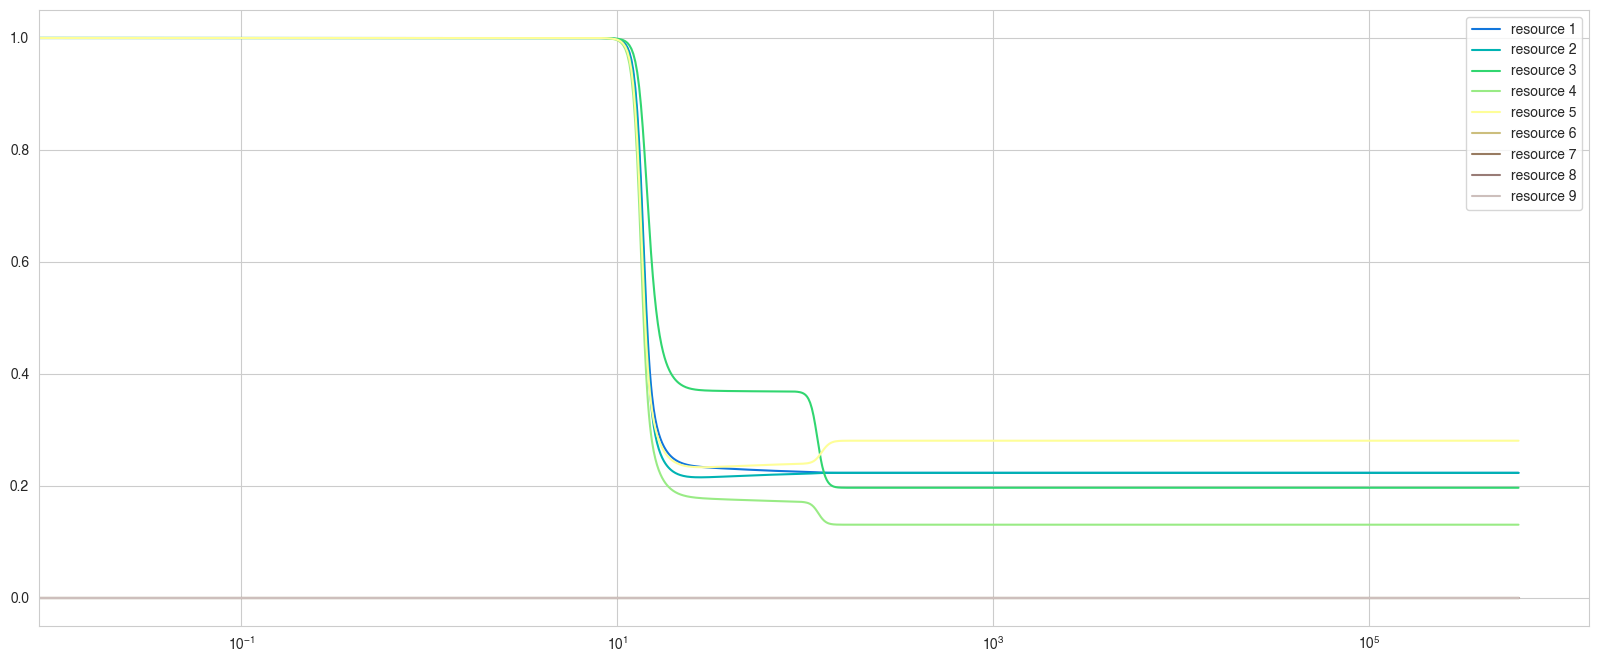

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
viz.resource_plot(system, ax=ax, stacked=False, relative=False, log_x_axis=True, log_y_axis=False)

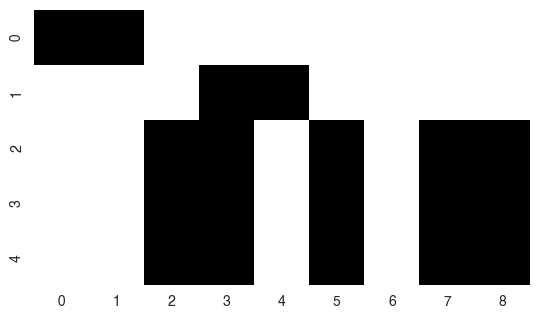

In [29]:
viz.matrix_plot(system.extant_type_set.traits)

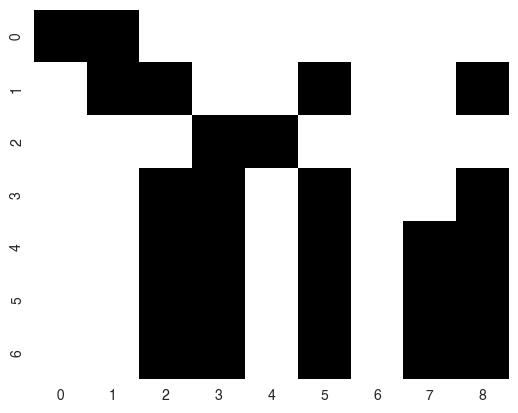

In [30]:
viz.matrix_plot(system.type_set.traits)